<a href="https://colab.research.google.com/github/costpetrides/NOx-Ozone-Relationship-Modeling-with-ML/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv('https://raw.githubusercontent.com/costpetrides/NOx-Ozone-Relationship-Modeling-with-ML/main/DATA/Data_2.csv')
cols = df.columns.tolist()
df.head()

,City,PM2.5,PM10,NOx,NH3,CO,SO2,O3
0,0,48.57,95.68,17.15,15.85,0.92,27.64,133.36
1,0,48.57,95.68,16.46,15.85,0.97,24.55,34.06
2,0,48.57,95.68,29.70,15.85,17.40,29.07,30.70
3,0,48.57,95.68,17.97,15.85,1.70,18.59,36.08
4,0,48.57,95.68,37.76,15.85,22.10,39.33,39.31


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Custom Regression Report:
Mean Absolute Error: 9.62
Mean Squared Error: 194.99
R-squared (R2): 0.52
Cross-Validated Mean Squared Error: 225.07


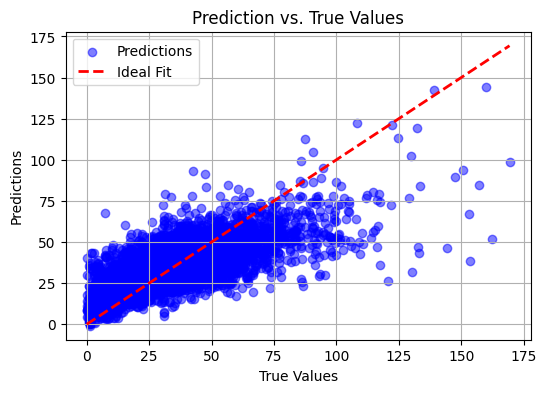

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/costpetrides/NOx-Ozone-Relationship-Modeling-with-ML/main/DATA/Data_2.csv')

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into training (60%), validation (20%), and test (20%) sets
train_end = int(0.6 * len(df))
valid_end = int(0.8 * len(df))

train = df[:train_end]
valid = df[train_end:valid_end]
test = df[valid_end:]

# Preprocessing function
def preprocess_data(dataframe, target_column):
    x = dataframe.drop(columns=[target_column]).values
    y = dataframe[target_column].values
    return x, y

# Apply preprocessing to datasets
train_x, train_y = preprocess_data(train, 'O3')
valid_x, valid_y = preprocess_data(valid, 'O3')
test_x, test_y = preprocess_data(test, 'O3')

# Standardize features (optional for XGBoost, but included here)
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)
test_x = scaler.transform(test_x)

# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter tuning using Grid Search
param_grid = {
    'colsample_bytree': [0.3, 0.5],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'alpha': [0, 10, 100],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3, verbose=1, n_jobs=-1)
grid_search.fit(train_x, train_y)

# Best model from Grid Search
best_xg_reg = grid_search.best_estimator_

# Train the best model
best_xg_reg.fit(train_x, train_y)

# Predict on the test set
pred_y = best_xg_reg.predict(test_x)

# Evaluate the model
mae = mean_absolute_error(test_y, pred_y)
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)

# Display the custom regression report
print("Custom Regression Report:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Cross-validation score
cv_scores = cross_val_score(best_xg_reg, test_x, test_y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated Mean Squared Error: {-np.mean(cv_scores):.2f}")

# Plot Prediction vs. True Values
plt.figure(figsize=(6, 4))
plt.scatter(test_y, pred_y, alpha=0.5, color='blue', label='Predictions')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], 'r--', linewidth=2, label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction vs. True Values')
plt.legend()
plt.grid(True)
plt.show()


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Improved Custom Regression Report:
Mean Absolute Error: 9.07
Mean Squared Error: 180.40
R-squared (R2): 0.56
Cross-Validated Mean Squared Error: 219.64
Improved Custom Regression Report with Polynomial Features:
Mean Absolute Error: 8.83
Mean Squared Error: 173.67
R-squared (R2): 0.57
Linear Regression - Custom Regression Report:
Mean Absolute Error: 14.05
Mean Squared Error: 373.83
R-squared (R2): 0.08

Random Forest - Custom Regression Report:
Mean Absolute Error: 9.08
Mean Squared Error: 183.41
R-squared (R2): 0.55

Support Vector Regression - Custom Regression Report:
Mean Absolute Error: 12.41
Mean Squared Error: 327.70
R-squared (R2): 0.20

Stacking Regressor - Custom Regression Report:
Mean Absolute Error: 9.00
Mean Squared Error: 179.24
R-squared (R2): 0.56


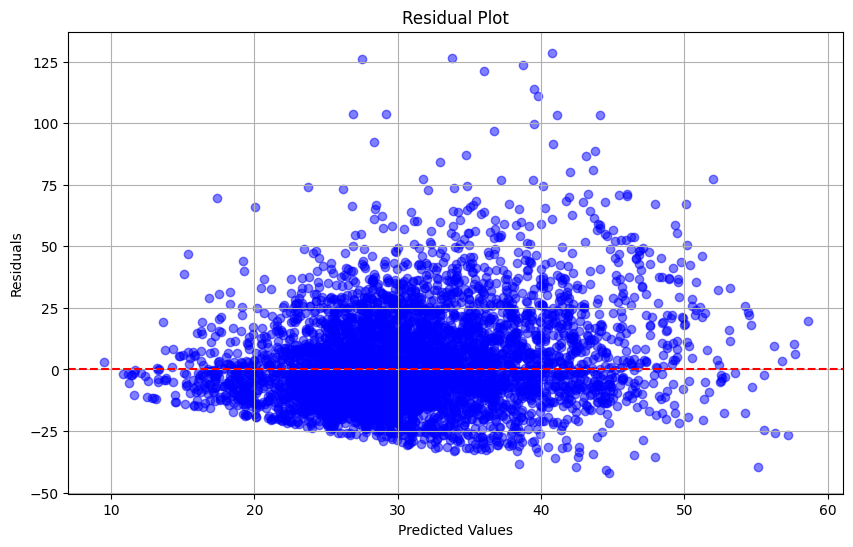

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter grid for Randomized Search
param_dist = {
    'colsample_bytree': uniform(0.3, 0.7),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'alpha': uniform(0, 100),
    'n_estimators': randint(50, 200)
}

random_search = RandomizedSearchCV(estimator=xg_reg, param_distributions=param_dist,
                                   n_iter=100, scoring='neg_mean_squared_error',
                                   cv=3, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(train_x, train_y)

# Best model from Randomized Search
best_xg_reg = random_search.best_estimator_

# Train and evaluate the best model
best_xg_reg.fit(train_x, train_y)
pred_y = best_xg_reg.predict(test_x)

mae = mean_absolute_error(test_y, pred_y)
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)

print("Improved Custom Regression Report:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Cross-validation score
cv_scores = cross_val_score(best_xg_reg, test_x, test_y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated Mean Squared Error: {-np.mean(cv_scores):.2f}")

from sklearn.preprocessing import PolynomialFeatures

# Example: Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
train_x_poly = poly.fit_transform(train_x)
valid_x_poly = poly.transform(valid_x)
test_x_poly = poly.transform(test_x)

# Standardize polynomial features
scaler_poly = StandardScaler()
train_x_poly = scaler_poly.fit_transform(train_x_poly)
valid_x_poly = scaler_poly.transform(valid_x_poly)
test_x_poly = scaler_poly.transform(test_x_poly)

# Train the model with polynomial features
best_xg_reg.fit(train_x_poly, train_y)
pred_y_poly = best_xg_reg.predict(test_x_poly)

# Evaluate
mae_poly = mean_absolute_error(test_y, pred_y_poly)
mse_poly = mean_squared_error(test_y, pred_y_poly)
r2_poly = r2_score(test_y, pred_y_poly)

print("Improved Custom Regression Report with Polynomial Features:")
print(f"Mean Absolute Error: {mae_poly:.2f}")
print(f"Mean Squared Error: {mse_poly:.2f}")
print(f"R-squared (R2): {r2_poly:.2f}")

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf')
}

# Evaluate each model
for name, model in models.items():
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)

    mae = mean_absolute_error(test_y, pred_y)
    mse = mean_squared_error(test_y, pred_y)
    r2 = r2_score(test_y, pred_y)

    print(f"{name} - Custom Regression Report:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared (R2): {r2:.2f}\n")

from sklearn.ensemble import StackingRegressor

# Define base models and meta-model
base_models = [
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)),
    ('rf', RandomForestRegressor(n_estimators=100))
]
meta_model = LinearRegression()

# Initialize and train the stacking model
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_regressor.fit(train_x, train_y)

# Predict and evaluate
pred_y_stack = stacking_regressor.predict(test_x)

mae_stack = mean_absolute_error(test_y, pred_y_stack)
mse_stack = mean_squared_error(test_y, pred_y_stack)
r2_stack = r2_score(test_y, pred_y_stack)

print("Stacking Regressor - Custom Regression Report:")
print(f"Mean Absolute Error: {mae_stack:.2f}")
print(f"Mean Squared Error: {mse_stack:.2f}")
print(f"R-squared (R2): {r2_stack:.2f}")

# Calculate residuals
residuals = test_y - pred_y

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(pred_y, residuals, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()
